## Import

In [3]:
import numpy as np

from mpmath import mp
from mpmath import cosh, sinh, tanh, exp, sqrt

from gwr_inversion import gwr #The package must be installed through "conda install gwr_inversion"
M_value = 32

import matplotlib.pyplot as plt

## Function and expression declarations

In [4]:
#Declare the expressions of the kernel, A and eta
def ker_sy (s, Oh, Bo, k, lbda):
    return 2*Oh/s*k*(k-lbda*tanh(k)) - Oh/s*(4*lbda*k*sinh(k)*(k*exp(-lbda)
            *(k*cosh(k)+lbda*sinh(k))-(k**2+lbda**2))+(k**2+lbda**2)**2
            *sinh(lbda))/(2*k*cosh(k)*(k*cosh(k)*sinh(lbda)-lbda*sinh(k)*cosh(lbda)))
            
def eta_sy (s, Oh, k, omega2, Kern):
    return 1/s*(1-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))
def ALaplace_sy (s, Oh, k, lbda, omega2, z, Kern):
    return 1/sinh(lbda)*(-(-2*k*lbda*sinh(k)+(k**2+lbda**2)*sinh(lbda))
             *sinh(lbda*z)/(k*(-lbda*cosh(lbda)*sinh(k)+k*cosh(k)*sinh(lbda)))
             +2*sinh(lbda*(1+z)))*(-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))

#Reduce the expressions as functions of s and of the parameters Oh, Bo and k
def freeSurfaceLaplace(s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return eta_sy(s, Oh, k, omega2, ker)

def vortiLaplace(s, z, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return k*ALaplace_sy (s, Oh, k, lbda, omega2, z, ker)

#Inverse the Laplace transfrom and return functions of t and of the parameters Oh, Bo and k
def freeSurface(t, Oh, Bo, k):
    return gwr(lambda s: freeSurfaceLaplace(s, Oh, Bo, k), t, M_value)

def vorti(t, z, Oh, Bo, k):
    return gwr(lambda s: vortiLaplace(s, z, Oh, Bo, k), t, M_value)
    

#Parameters figures
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage[squaren,Gray]{SIunits} \usepackage{nicefrac}'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
#font size
plt.rc('font', size=10)  # general font size
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('lines', markersize=8, markeredgewidth=0., linewidth=0.4)
plt.rc('legend', frameon=False, fancybox=False, numpoints=1, markerscale=1, 
       fontsize=10, handlelength=0.6, handletextpad=0.6, labelspacing=0.3)
plt.rc('xtick',  labelsize=8, direction='in', bottom='true', top='true')
plt.rc('ytick',  labelsize=8, direction='in', left='true', right='true')
plt.rc('savefig', bbox='tight', transparent=True, dpi=300)    

## Main function

In [5]:
def solveEta(Ohnumb, Bonumb, knumb, nbOfrelax):
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    
    #Resolution functions with numerical Laplace Transform GWR. Oh_, Bo_ and k_ must have been defined before
    def eta(t):
        return float(freeSurface(t, Oh, Bo, k))
       
    #Time resolutions
    tau_relax = float(3*(Oh/(k**2*Bo+k**4)))
    t_all = np.linspace(0.01, 1., 100) * nbOfrelax * abs(tau_relax)
    
    #solve the equation on eta with Cortelezzi model and lubrication
    sampled_t = abs(t_all/tau_relax)
    sampled_eta = [eta(t) for t in t_all]
    sampled_eta_lub = [np.exp(-t/tau_relax) for t in t_all]
    
    return sampled_t, sampled_eta, sampled_eta_lub

def solveOmega(Ohnumb, Bonumb, knumb, nbOfrelax, toI, z_all):
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    
    def omega(t, z_):    
        return float(vorti(t, z_, Oh, Bo, k))
       
    #Spatial and time resolutions
    tau_relax = abs(float(3*(Oh/(k**2*Bo+k**4))))
    t_all = np.linspace(0.01, 1., 200) * nbOfrelax * tau_relax
    timesOfInterest = np.array(toI)*tau_relax

    #determine the maximal value of vorticity
    vortmax = [abs(omega(t, mp.mpmathify(z_all[0]))) for t in t_all]
    maxv = max(np.array(vortmax))
    
    #solve the equation on omega with Cortelezzi model and lubrication
    sampled_omega = np.array([[2*i+omega(timesOfInterest[i], mp.mpmathify(z))/maxv
        for i in range(len(timesOfInterest))] for z in z_all])
    sampled_omega_lub = np.array([[2*i+float(k**3/Oh+k*Bo/Oh)*(-z)
        *np.exp(-timesOfInterest[i]/tau_relax)/maxv
        for i in range(len(timesOfInterest))] for z in z_all])
    
    return sampled_omega, sampled_omega_lub

# Relaxation time

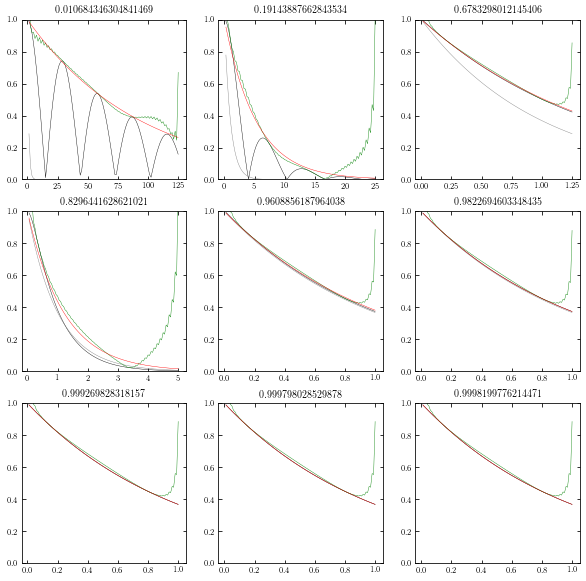

In [6]:
from scipy.optimize import curve_fit
def decaying_sinusoid(t, om, k):
    return np.exp(-om * t)* np.cos(k * t)

from scipy.signal import hilbert

def plotHeight(Ohnumb, Bonumb, knumb, nbOfrelax, ax):
    sampled_t, sampled_eta, sampled_eta_lub = solveEta(Ohnumb, Bonumb, knumb, max(1.,knumb**2/Ohnumb * 5.))
    popt, pcov = curve_fit(decaying_sinusoid, sampled_t,sampled_eta, p0=(0.1, 0.))

    om_cort = popt[0]
    dacaying = np.exp(-om_cort * sampled_t)
    enveloppe = np.abs(hilbert(sampled_eta))
    
    om_lub = float((knumb**2*Bonumb+knumb**4)/3*Ohnumb)
    om_0 = np.sqrt(abs((Bonumb+knumb**2)*knumb*np.tanh(knumb)))
    om_diff = knumb**2/Ohnumb
    
    ax.set_title(om_cort)
    ax.plot(sampled_t,np.abs(sampled_eta), 'black', label = r'Cortelezzi \& Prosperetti')
    ax.plot(sampled_t,sampled_eta_lub, 'grey', label = 'Lubricaion theory')
    ax.plot(sampled_t,enveloppe, 'green', label = 'Enveloppe')
    ax.plot(sampled_t,dacaying, 'red', label = 'Decaying')
    ax.set_ylim([0,1])
    
Oh_list = [0.01, 0.05, 1.]
k_list =  [0.5, 0.1, 0.01]

fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize=(10, 10))
j = 0
for Oh in Oh_list:
    i = 0
    for k in k_list:
        plotHeight(Oh, 0.001, k, 10., ax[i,j])
        i+=1
    j+=1

# With Vorticity

In [ ]:
def plotComparison(Ohnumb, Bonumb, knumb, nbOfrelax, toI = [0.05, 0.1]):
    
    sampled_t, sampled_eta, sampled_eta_lub = \
        solveEta(Ohnumb, Bonumb, knumb, nbOfrelax)
    
    z_all = np.linspace(-1, 0, 200)
    sampled_omega, sampled_omega_lub = \
        solveOmega(Ohnumb, Bonumb, knumb, nbOfrelax, toI, z_all)
    
    ### Figures ###
    
    plt.rc('figure', figsize=[6/2.54, 6/2.54])
    plt.figure()
    plt.xlabel(r'Time (in $\tau_{relax}$ units)')
    plt.ylabel("Relative wave amplitude")
    plt.xlim([0,nbOfrelax])
    plt.ylim([0,1])
    plt.rc('legend', loc='best')
    
    plt.plot(sampled_t,sampled_eta, 'black', label = r'Cortelezzi \& Prosperetti')
    plt.plot(sampled_t,sampled_eta_lub, 'gray', label = 'Lubricaion theory')
    plt.legend()
    plt.savefig('Oh_' + str(Ohnumb) + '_k_' + str(knumb) + '_eta.png')
    plt.tight_layout(pad=0.)

    plt.figure(figsize=[6./2.54, 6./2.54])
    plt.xlabel('Scaled vorticity')
    plt.ylabel('depth z')
    plt.xlim([-0.5, 2*len(sampled_omega[0])-0.5])
    plt.ylim([-1,0])
    plt.rc('legend', loc='best')
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    plt.tight_layout(pad=0.)
    
    for i in range(len(sampled_omega[0])):
        plt.plot(sampled_omega[:,i], z_all, 'r')
        plt.plot(2*i*np.ones(len(z_all)), z_all, 'r')
        plt.fill_betweenx(z_all, sampled_omega[:,i], 2*i, color = 'red', alpha=0.20)
        plt.plot(sampled_omega_lub[:,i],z_all, c = 'gray', linewidth=1, linestyle='dashed')
        plt.text(2.*i+0.2, -0.1, str(toI[i]) + r'$\tau_{relax}$', size=8)

    plt.savefig('Oh_' + str(Ohnumb) + '_k_' + str(knumb) + '_omg.png')

### Oh = 10, Bo = 0.001, k = 0.1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


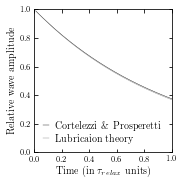

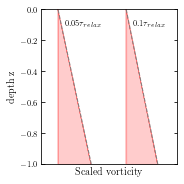

In [6]:
plotComparison(10, 0.001, 0.1, 1)                   # oilly film 

### Oh = 0.01, Bo = 0.001, k = 0.1

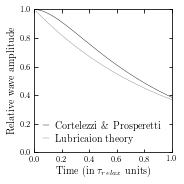

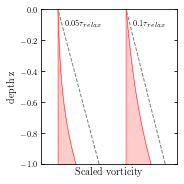

In [7]:
plotComparison(0.01, 0.001, 0.1, 1)                 # waterborne coating

### Oh = 0.005, Bo = 0.001, k = 0.1

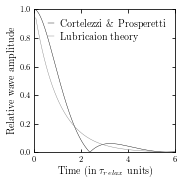

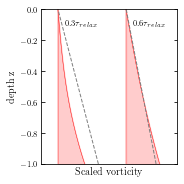

In [8]:
plotComparison(0.005, 0.001, 0.1, 6, [0.3, 0.6])    # oscillations

# Feuilletage

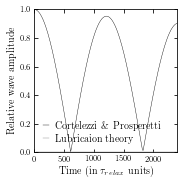

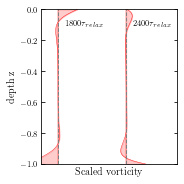

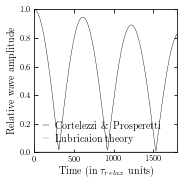

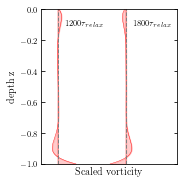

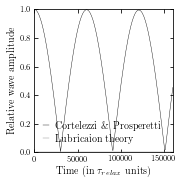

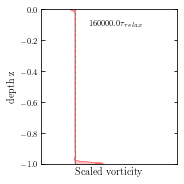

In [11]:
plotComparison(0.005, 0.001, 2., 2400, [1800, 2400])
plotComparison(0.005, 0.001, 1.5, 1800, [1200, 1800])
plotComparison(1e-4, 0.001, 2., 1./6.25e-6, [1./6.25e-6]) #tau = (Oh/k**4)

## Feuilletage simplifié

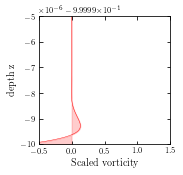

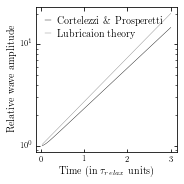

In [12]:
def Feuilletage(Ohnumb, Bonumb, knumb, nbOfrelax, toI = [0.05, 0.1]):

    plt.rc('figure', figsize=[6/2.54, 6/2.54])   
    z_all = np.linspace(-1, -0.999995, 1000)
    sampled_omega, sampled_omega_lub = \
        solveOmega(Ohnumb, Bonumb, knumb, nbOfrelax, toI, z_all)
    
    ### Figures ###
    plt.xlabel('Scaled vorticity')
    plt.ylabel('depth z')
    plt.xlim([-0.5, 1.5])
    plt.ylim([-1,-0.999995])

    plt.plot(sampled_omega[:,0], z_all, 'r')
    plt.fill_betweenx(z_all, sampled_omega[:,0], 0., color = 'red', alpha=0.20)
    
Oh = 1e-10
k = 100.
tau = (Oh/k**4)
Feuilletage(Oh, 0.001, k, 5.e-3/tau, [5.25e-3/tau])
 
sampled_t, sampled_eta, sampled_eta_lub = \
    solveEta(0.01, -0.03, 0.05, 3.)
plt.rc('figure')
plt.rc('legend', loc='best')

plt.figure()
plt.xlabel(r'Time (in $\tau_{relax}$ units)')
plt.ylabel("Relative wave amplitude")
 #   plt.xlim([0,nbOfrelax])
 #   plt.ylim([1,10.])
plt.semilogy(sampled_t,sampled_eta, 'black', label = r'Cortelezzi \& Prosperetti')
plt.semilogy(sampled_t,sampled_eta_lub, 'gray', label = 'Lubricaion theory')
plt.legend()
plt.tight_layout(pad=0.)

# Rayleigh-Taylor

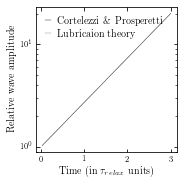

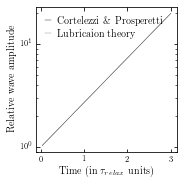

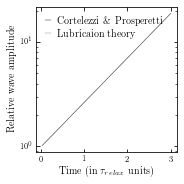

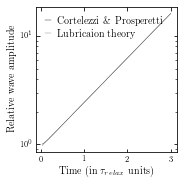

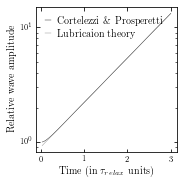

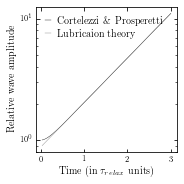

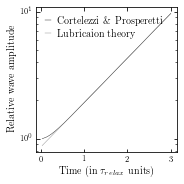

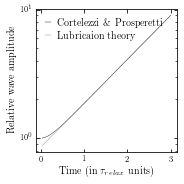

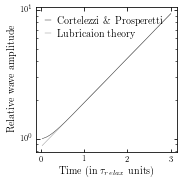

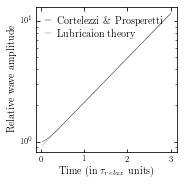

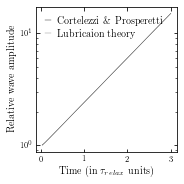

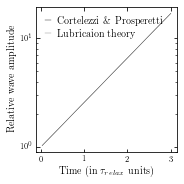

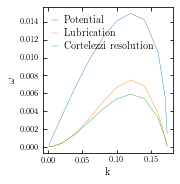

In [13]:
k_list = [0.001, 0.008, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.17, 0.173]
om_list=[]
om_lub_list =[]
om_cort_lub = []
for k in k_list:
    Ohnumb, Bonumb, knumb, nbOfrelax, toI = 0.01, -0.03, k, 3., [3.]
    
    sampled_t, sampled_eta, sampled_eta_lub = \
        solveEta(Ohnumb, Bonumb, knumb, nbOfrelax)
        
    om, a0 = np.polyfit(sampled_t[20:], np.log(sampled_eta[20:]), 1)
    
    tau_relax = abs(float(3*(Ohnumb/(knumb**2*Bonumb+knumb**4))))
    om_list.append(om/tau_relax)
    om_lub_list.append(1./tau_relax)
    om_cort_lub.append(np.sqrt(abs((Bonumb+knumb**2)*knumb*np.tanh(knumb))))
    ### Figures ###
    if True:
        plt.rc('figure', figsize=[6/2.54, 6/2.54])
        plt.figure()
        plt.xlabel(r'Time (in $\tau_{relax}$ units)')
        plt.ylabel("Relative wave amplitude")
         #   plt.xlim([0,nbOfrelax])
         #   plt.ylim([1,10.])
        plt.rc('legend', loc='best')
        
        plt.semilogy(sampled_t,sampled_eta, 'black', label = r'Cortelezzi \& Prosperetti')
#        plt.semilogy(sampled_t,sampled_eta_lub, 'gray', label = 'Lubricaion theory')
        plt.semilogy(sampled_t,np.exp(a0 + sampled_t*om), 'gray', label = 'Lubricaion theory')
        plt.legend()
        plt.savefig('Oh_' + str(Ohnumb) + '_k_' + str(knumb) + '_eta.png')
        plt.tight_layout(pad=0.)
        
        plt.savefig('Oh_' + str(Ohnumb) + '_k_' + str(knumb) + '_omg.png')


  
plt.figure()
plt.xlabel(r'k')
plt.ylabel(r'$\omega$')
plt.plot(k_list, om_cort_lub, label = r'Potential')
plt.plot(k_list, om_lub_list, label = r'Lubrication')
plt.plot(k_list, om_list, label = r'Cortelezzi resolution')
plt.legend()
plt.tight_layout(pad=0.)

## Rayleigh-Taylor : different periods

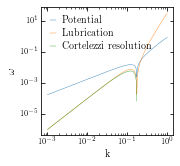

In [14]:
knumb = 10**np.linspace(-3,0,1000)
Ohnumb, Bonumb, nbOfrelax, toI = 0.01, -0.03, 3., [3.]

tau_relax = np.abs(3*(Ohnumb/(knumb**2*Bonumb+knumb**4)))
om_lub_list = (1./tau_relax)
om_cort_lub = (np.sqrt(np.abs((Bonumb+knumb**2)*knumb*np.tanh(knumb))))

plt.figure()
plt.xlabel(r'k')
plt.ylabel(r'$\omega$')
plt.loglog(knumb, om_cort_lub, label = r'Potential')
plt.loglog(knumb, om_lub_list, label = r'Lubrication')
plt.plot(k_list, om_list, label = r'Cortelezzi resolution')
plt.legend()